<a href="https://colab.research.google.com/github/elvanselvano/sunibatik/blob/main/Segmentation_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
!pip install scikit-image

In [ ]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
import skimage.transform as transform

import cv2

# Load Image

In [ ]:
def render_image(image, color='rgb'):
    plt.figure(figsize = (8, 6))
    if color == 'gray':
      plt.imshow(image, cmap='gray')
    else:
      plt.imshow(image)
    plt.axis('off')
    plt.show()

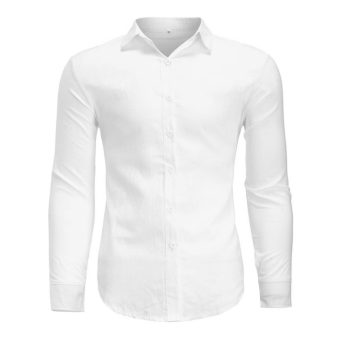

In [ ]:
t_shirt = io.imread('shirt.jpeg')

render_image(t_shirt)

#Histogram

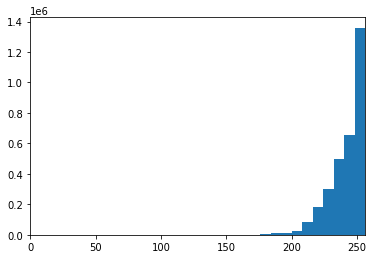

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(t_shirt.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)
plt.show()

# Supervised Segmentation

In [ ]:
def show_img(image, cmap='gray'):
  fig, ax = plt.subplots(1, 1)
  ax.imshow(image, cmap=cmap)
  ax.axis('off')
  return fig, ax

## Active contour segmentation

Active Contour segmentation also called snakes is initialized using a user-defined contour or line, around the area of interest, and this contour then slowly contracts and is attracted or repelled from light and edges.

For our example image, let’s draw a circle around the t-shirt to initialize the snake.

In [ ]:
def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T

# Exclude last point because a closed path should not have duplicate points
points = circle_points(200, [510, 510], 600)[:-1]



> The above calculations calculate x and y co-ordinates of the points on the periphery of the circle. Since we have given the resolution to be 200, it will calculate 200 such points.



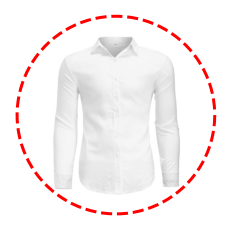

In [ ]:
fig, ax = show_img(t_shirt)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
plt.show()

The algorithm then segments the face of a person from the rest of an image by fitting a closed curve to the edges of the face.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  """Entry point for launching an IPython kernel.


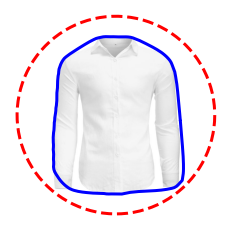

In [ ]:
snake = seg.active_contour(t_shirt, points)

fig, ax = show_img(t_shirt)

ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
plt.show()

We can tweak the parameters called `alpha` and `beta`. Higher values of alpha will make this snake contract faster while beta makes the snake smoother.

Default values:
- `alpha`: 0.01
- `beta`: 0.1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  """Entry point for launching an IPython kernel.


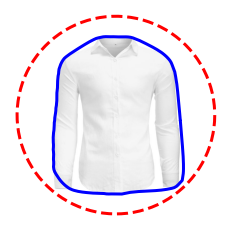

In [ ]:
snake = seg.active_contour(t_shirt, points, alpha=0.01, beta=0.1)

fig, ax = show_img(t_shirt)

ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
plt.show()

# Make Mask

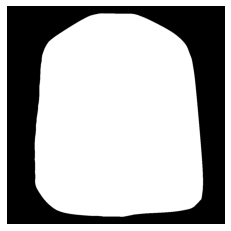

In [ ]:
IMG_SHAPE = (1024, 1024)

mask = transform.rotate(draw.polygon2mask(IMG_SHAPE, snake), -90)[:, ::-1]
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

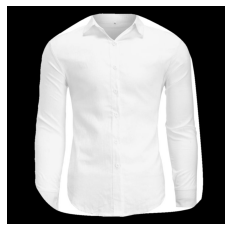

In [ ]:
mask = np.array(mask, dtype=np.uint8)
t_shirt = np.array(t_shirt, dtype=np.uint8)

masked = cv2.bitwise_and(t_shirt, t_shirt, mask=mask)
plt.imshow(masked)
plt.axis('off')
plt.show()

#Tidying Up

In [ ]:
def show_img(image, cmap='gray'):
  fig, ax = plt.subplots(1, 1)
  ax.imshow(image, cmap=cmap)
  plt.axis('off')
  return fig, ax

In [ ]:
def circle_points(resolution, center, radius):
  """
  Generate points which define a circle on an image.Centre refers to the centre of the circle
  """   
  radians = np.linspace(0, 2*np.pi, resolution)
  c = center[1] + radius*np.cos(radians)#polar co-ordinates
  r = center[0] + radius*np.sin(radians)
  
  return np.array([c, r]).T

In [ ]:
def detect_tshirt(filename, x, y, radius, alpha=0.01, beta=0.1):
  """
  Detect shirt from an image using a mask
  """
  image = io.imread(filename)

  points = circle_points(200, [y, x], radius)[:-1]
  snake = seg.active_contour(image, points, alpha=alpha, beta=beta)

  fig, ax = show_img(image)
  
  # Plot circle and snake
  ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
  ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
  plt.show()

  IMG_SHAPE = image.shape[:2]

  # Make mask
  mask = transform.rotate(draw.polygon2mask(IMG_SHAPE, snake), -90)[:, ::-1]

  mask = np.array(mask, dtype=np.uint8)
  image = np.array(image, dtype=np.uint8)

  masked = cv2.bitwise_and(image, image, mask=mask)

  # Show cropped
  plt.figure(figsize=(8, 6))
  plt.imshow(masked)
  plt.axis('off')
  plt.show()

  # Save cropped file
  filename = filename[:filename.find('.')]
  output_filename = filename + '_masked.jpg'
  io.imsave(filename + '_masked.jpg', masked)

  print("Saved to " + output_filename)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  


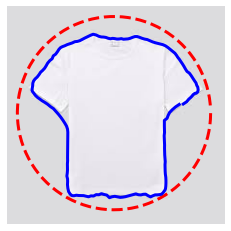

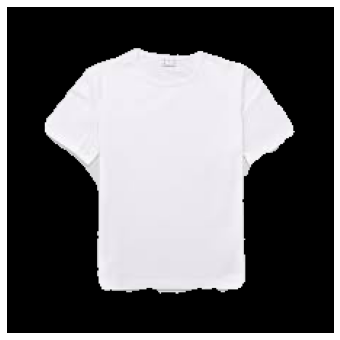

Saved to white_masked.jpg


In [ ]:
detect_tshirt('white.jpg', 110, 110, 100, alpha=0.06, beta=0.2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  


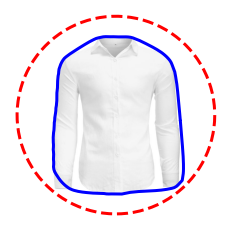

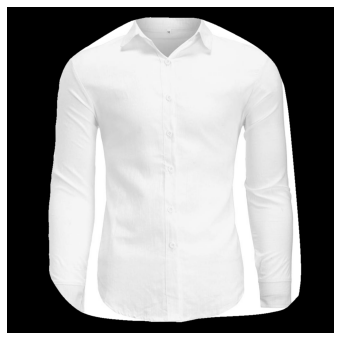

Saved to shirt_masked.jpg


In [ ]:
detect_tshirt('shirt.jpeg', 510, 510, 600)

# References

[Image Segmentation using Python’s scikit-image module](https://towardsdatascience.com/image-segmentation-using-pythons-scikit-image-module-533a61ecc980)